In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""

  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device)

In [2]:
device = get_default_device()

print(device)

cuda


In [3]:
def accuracy(net, testloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    net.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = to_device(data, device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.to(device)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total):.6f} %')

    return (100 * correct / total)

In [4]:
def classAccuracy(net, testloader, classes):
    # prepare to count predictions for each class
    net.eval()
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            inputs, labels = to_device(data, device)
            outputs = net(inputs)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred

def printClassAccuracy(net, testloader, classes):
    correct_pred, total_pred = classAccuracy(net, testloader, classes)
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.4f} %')

In [5]:
from tqdm.notebook import tqdm

def trainNN(net, criterion, optimizer, trainloader, validationloader = None, numEpochs = 20, scheduler = None):
    epochLosses = []
    epochAccuracy = []
    epochValAccuracy = [] if validationloader is not None else None

    lossVal = 0
    accuracyVal = 0
    valAccuracyVal = 0

    for epoch in range(numEpochs):  # loop over the dataset multiple times
        correct = 0
        total = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            for data in tepoch:
                # get the inputs; data is a list of [inputs, labels]
                net.train()
                inputs, labels = to_device(data, device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                lossVal = loss.item()
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted.to(device)
                correct += (predicted == labels).float().sum()
                total += len(labels)
                accuracyVal = float(100 * correct / total)
                if validationloader is None:
                    tepoch.set_postfix(loss=lossVal, accuracy=accuracyVal) 
                else:
                    tepoch.set_postfix(loss=lossVal, accuracy=accuracyVal, validation=valAccuracyVal)
        
        epochLosses.append(lossVal)
        epochAccuracy.append(accuracyVal)
        if validationloader is not None:
            valAccuracyVal = accuracy(net, validationloader)
            epochValAccuracy.append(valAccuracyVal)
        
        if scheduler is not None:
            scheduler.step()
        
    return epochLosses, epochAccuracy, epochValAccuracy

In [6]:
import seaborn as sns
import pandas as pd
def accuracyplot(trainacc, valacc):
    data = pd.DataFrame({
        'x': np.arange(1, len(trainacc) + 1),
        'train': trainacc,
        'val': valacc
    })
    return sns.lineplot(x='x', y='value', hue='variable', data=pd.melt(data, ['x']))

In [7]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 256
validationSize = 0.2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
totaltrainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
trainset, valset = random_split(
    trainset, 
    [len(trainset) - int(validationSize * len(trainset)), int(validationSize * len(trainset))],
    generator=torch.Generator().manual_seed(42)
)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

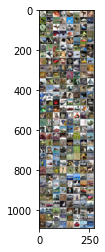

cat   car   dog   truck truck horse horse bird  bird  dog   deer  deer  plane bird  car   car   bird  frog  plane plane truck dog   car   plane horse deer  car   deer  truck truck frog  bird  horse truck horse cat   cat   ship  car   truck horse deer  horse car   car   deer  deer  horse dog   plane frog  dog   car   plane car   truck bird  cat   car   car   cat   ship  ship  horse deer  bird  dog   dog   bird  car   deer  deer  frog  truck horse dog   horse horse dog   cat   ship  deer  frog  deer  horse horse dog   plane deer  plane ship  horse truck cat   deer  ship  truck ship  ship  cat   bird  frog  dog   truck car   horse car   ship  horse car   horse car   horse plane deer  truck car   truck bird  cat   dog   frog  cat   frog  dog   truck car   dog   bird  dog   truck bird  bird  plane dog   car   bird  frog  car   bird  plane horse dog   truck horse horse cat   cat   horse bird  deer  ship  truck bird  deer  deer  frog  bird  ship  dog   dog   dog   ship  truck bird  deer  cat 

In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

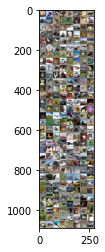

truck bird  dog   cat   bird  frog  cat   cat   truck ship  bird  bird  bird  deer  frog  cat   dog   frog  horse dog   cat   truck horse dog   truck bird  car   ship  dog   plane frog  deer  truck bird  horse cat   horse car   plane bird  dog   dog   bird  plane plane plane plane dog   deer  horse plane frog  cat   ship  horse horse truck car   cat   car   deer  ship  bird  car   car   horse dog   horse horse frog  ship  frog  frog  ship  cat   horse deer  car   horse truck dog   cat   horse ship  plane dog   bird  bird  frog  cat   dog   car   frog  truck dog   bird  cat   deer  ship  car   cat   horse frog  horse frog  dog   frog  car   car   car   ship  car   dog   frog  cat   horse horse dog   horse deer  truck plane plane ship  cat   bird  frog  cat   bird  deer  dog   car   frog  cat   truck horse horse plane plane dog   horse cat   horse plane truck horse bird  car   dog   plane dog   horse truck cat   horse car   truck truck dog   dog   bird  dog   truck dog   ship  horse dog 

In [10]:
# get some random validation images
dataiter = iter(valloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
from torchviz import make_dot

# LeNet (with ReLu instead of sigmoid)

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class LeNetReLu(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = LeNetReLu()
net.to(device)

LeNetReLu(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

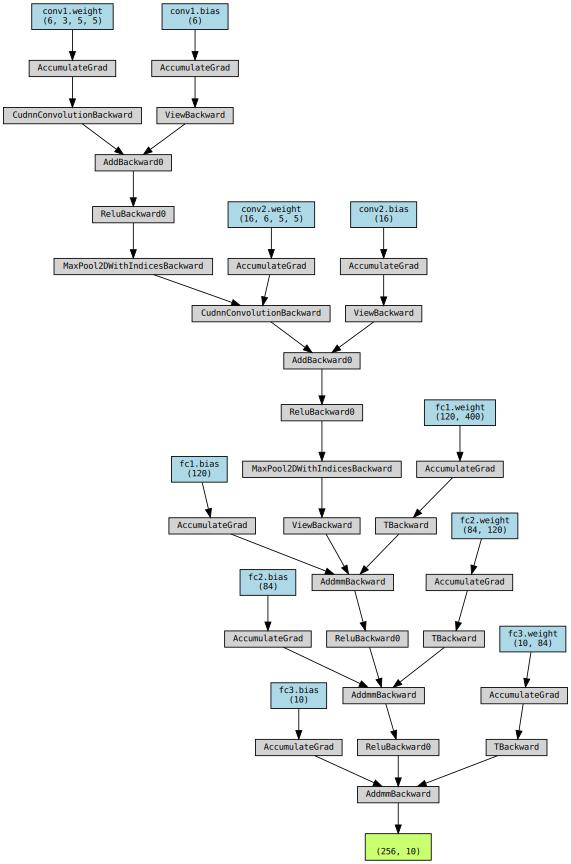

In [23]:
dataiter = iter(valloader)
images, labels = to_device(dataiter.next(), device)
temp = net(images)
make_dot(temp, params=dict(list(net.named_parameters())))

## 1) Non-zero Momentum without adaptive learning

In [24]:
import torch.optim as optim

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [25]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50)

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

<AxesSubplot:xlabel='x', ylabel='value'>

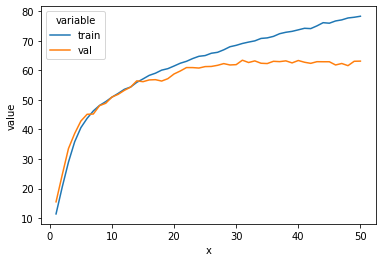

In [26]:
accuracyplot(trAcc, valAcc)

In [27]:
printClassAccuracy(net, valloader, classes)

Accuracy for class: plane is 66.5982 %
Accuracy for class: car   is 74.3564 %
Accuracy for class: bird  is 48.3101 %
Accuracy for class: cat   is 42.5026 %
Accuracy for class: deer  is 57.0093 %
Accuracy for class: dog   is 50.0000 %
Accuracy for class: frog  is 80.7805 %
Accuracy for class: horse is 64.4444 %
Accuracy for class: ship  is 74.3487 %
Accuracy for class: truck is 71.8719 %


In [28]:
accuracy(net, testloader)

62.12

In [29]:
net = LeNetReLu()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [30]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=30)

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

In [31]:
accuracy(net, testloader)

64.02

## 2) Zero Momentum without Adaptive Learning

In [52]:
import torch.optim as optim

net = LeNetReLu()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0)

In [53]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=75)

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

<AxesSubplot:xlabel='x', ylabel='value'>

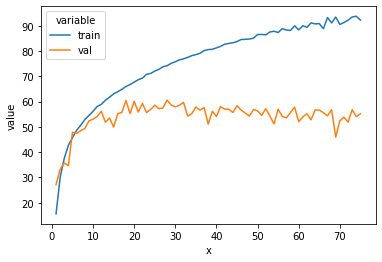

In [54]:
accuracyplot(trAcc, valAcc)

In [55]:
printClassAccuracy(net, valloader, classes)

Accuracy for class: plane is 62.2816 %
Accuracy for class: car   is 66.2376 %
Accuracy for class: bird  is 55.1690 %
Accuracy for class: cat   is 31.6443 %
Accuracy for class: deer  is 40.3946 %
Accuracy for class: dog   is 24.7070 %
Accuracy for class: frog  is 54.7317 %
Accuracy for class: horse is 70.2415 %
Accuracy for class: ship  is 74.5491 %
Accuracy for class: truck is 70.8709 %


In [56]:
accuracy(net, testloader)

54.92

In [37]:
net = LeNetReLu()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)

In [49]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=100)

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
accuracy(net, testloader)

## 3) Non-zero Momentum with Adaptive Learning

In [ ]:
import torch.optim as optim

net = LeNetReLu()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50, scheduler=scheduler)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, testloader, classes)

In [ ]:
accuracy(net, testloader)

In [15]:
net = LeNetReLu()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

TypeError: ignored

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=25,scheduler=scheduler)

In [ ]:
accuracy(net, testloader)

## 4) Without Momentum and with Adaptive Learning

In [ ]:
import torch.optim as optim

net = LeNetReLu()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50, scheduler=scheduler)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, testloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = LeNetReLu()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=25,scheduler=scheduler)

In [ ]:
accuracy(net, testloader)

# LeNet With Sigmoid

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))
        x = self.pool(torch.sigmoid(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


net = LeNet()
net.to(device)

## 1) Non-zero Momentum without adaptive learning

In [ ]:
import torch.optim as optim

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, valloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = LeNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=30)

In [ ]:
accuracy(net, testloader)

## 2) Zero Momentum without Adaptive Learning

In [ ]:
import torch.optim as optim

net = LeNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, valloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = LeNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=30)

In [ ]:
accuracy(net, testloader)

## 3) Non-zero Momentum with Adaptive Learning

In [ ]:
import torch.optim as optim

net = LeNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50, scheduler=scheduler)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, testloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = LeNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=25,scheduler=scheduler)

In [ ]:
accuracy(net, testloader)

## 4) Without Momentum and with Adaptive Learning

In [ ]:
import torch.optim as optim

net = LeNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50, scheduler=scheduler)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, testloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = LeNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=25)

In [ ]:
accuracy(net, testloader)

# LeNet with tanh as activation function

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = LeNet_tanh()
net.to(device)

LeNet_tanh(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 1) Non-zero Momentum without adaptive learning

In [13]:
import torch.optim as optim

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, valloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = LeNet_tanh()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=30)

In [ ]:
accuracy(net, testloader)

## 2) Zero Momentum without Adaptive Learning

In [ ]:
import torch.optim as optim

net = LeNet_tanh()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, valloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = LeNet_tanh()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=30)

In [ ]:
accuracy(net, testloader)

## 3) Non-zero Momentum with Adaptive Learning

In [27]:
import torch.optim as optim

net = LeNet_tanh()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [28]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50, scheduler=scheduler)

  0%|          | 0/157 [00:00<?, ?batch/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

KeyboardInterrupt: ignored

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, testloader, classes)

In [ ]:
accuracy(net, testloader)

In [22]:
net = LeNet_tanh()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [23]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=25,scheduler=scheduler)

  0%|          | 0/196 [00:00<?, ?batch/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

  0%|          | 0/196 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/196 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dis

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

In [ ]:
accuracy(net, testloader)

## 4) Without Momentum and with Adaptive Learning

In [29]:
import torch.optim as optim

net = LeNet_tanh()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [30]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50, scheduler=scheduler)

  0%|          | 0/157 [00:00<?, ?batch/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
Traceback (most recent call last):
    assert self._pa

  0%|          | 0/157 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

  0%|          | 0/157 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8deb9b15f0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

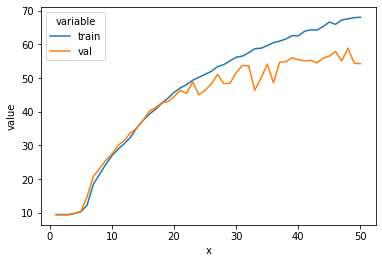

In [31]:
accuracyplot(trAcc, valAcc)

In [32]:
printClassAccuracy(net, testloader, classes)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy for class: plane is 46.0000 %
Accuracy for class: car   is 38.2000 %
Accuracy for class: bird  is 36.3000 %
Accuracy for class: cat   is 36.4000 %
Accuracy for class: deer  is 74.5000 %
Accuracy for class: dog   is 47.4000 %
Accuracy for class: frog  is 40.6000 %
Accuracy for class: horse is 61.7000 %
Accuracy for class: ship  is 83.4000 %
Accuracy for class: truck is 79.7000 %


In [33]:
accuracy(net, testloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


54.42

In [34]:
net = LeNet_tanh()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [35]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=25,scheduler=scheduler)

  0%|          | 0/196 [00:00<?, ?batch/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

  0%|          | 0/196 [00:00<?, ?batch/s]

In [36]:
accuracy(net, testloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


53.27

# AlexNet

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.conv5 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(288, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = AlexNet()
net.to(device)

AlexNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 1) Non-zero Momentum without adaptive learning

In [14]:
import torch.optim as optim

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=75)

  0%|          | 0/157 [00:00<?, ?batch/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

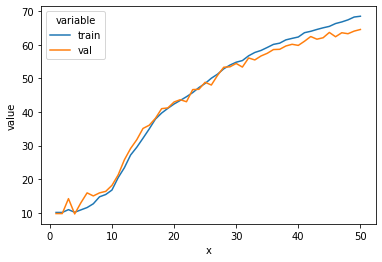

In [40]:
accuracyplot(trAcc, valAcc)

In [41]:
printClassAccuracy(net, valloader, classes)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy for class: plane is 68.2425 %
Accuracy for class: car   is 77.8218 %
Accuracy for class: bird  is 41.9483 %
Accuracy for class: cat   is 46.3289 %
Accuracy for class: deer  is 60.1246 %
Accuracy for class: dog   is 48.6328 %
Accuracy for class: frog  is 75.1220 %
Accuracy for class: horse is 66.5700 %
Accuracy for class: ship  is 78.6573 %
Accuracy for class: truck is 81.8819 %


In [42]:
accuracy(net, testloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


64.37

In [43]:
net = AlexNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [1]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=30)

NameError: ignored

In [45]:
accuracy(net, testloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


59.0

## 2) Zero Momentum without Adaptive Learning

In [ ]:
import torch.optim as optim

net = AlexNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, valloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = AlexNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=30)

In [ ]:
accuracy(net, testloader)

## 3) Non-zero Momentum with Adaptive Learning

In [ ]:
import torch.optim as optim

net = AlexNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50, scheduler=scheduler)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, testloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = AlexNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=25,scheduler=scheduler)

In [ ]:
accuracy(net, testloader)

## 4) Without Momentum and with Adaptive Learning

In [ ]:
import torch.optim as optim

net = AlexNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, trainloader, valloader, numEpochs=50, scheduler=scheduler)

In [ ]:
accuracyplot(trAcc, valAcc)

In [ ]:
printClassAccuracy(net, testloader, classes)

In [ ]:
accuracy(net, testloader)

In [ ]:
net = AlexNet()
net.to(device)

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
lambda1 = lambda epoch : epoch//3 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambda1])

In [ ]:
loss, trAcc, valAcc = trainNN(net, criterion, optimizer, totaltrainloader, numEpochs=25,scheduler=scheduler)

In [ ]:
accuracy(net, testloader)